# Clustream

In [1]:
import pandas as pd
import math
import numpy as np
from collections import Counter
from scipy.spatial import distance
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
import warnings
warnings.filterwarnings('ignore')

file = 'C:\\My Files\\OVGU\\Hiwi\\data mining 2\\advanced-data-mining\\data\\data.csv'

"""
mine, slide
mc1: mc2
mc2: mc3
mc3: mc4
mc4: mc5
mc5: mc1
"""

'\nmine, slide\nmc1: mc2\nmc2: mc3\nmc3: mc4\nmc4: mc5\nmc5: mc1\n'

### Data points from T1 to T11 are the initial points, so we will apply K-Means on this initial set of points

In [2]:
full_data = pd.read_csv(file).set_index('T')
initial = full_data[0:11].copy()
online = full_data[11:].copy()
initial

,X,Y
T,,
1,6.0,2.0
2,7.0,3.0
3,6.5,1.0
4,1.0,1.0
5,2.0,2.0
6,3.0,1.0
7,3.0,2.5
8,2.0,8.0
9,2.0,6.0


### The following points are used as the initial centroids

In [3]:
d = {'Centers': ['C1', 'C2', 'C3', 'C4', 'C5'], 'X': [1, 2.5, 2, 4, 6], 'Y': [1, 2, 7, 7, 2]}
centroids = pd.DataFrame(d).set_index('Centers')
centroids

,X,Y
Centers,,
C1,1.0,1
C2,2.5,2
C3,2.0,7
C4,4.0,7
C5,6.0,2


### Now we will apply K-Means on the initial data points, and assign every point to its nearest centroid.
### After K-Means converges, the final centroids and the assignment of each point are plotted below

,X,Y,Centroid
T,,,
1,6.0,2.0,MC5
2,7.0,3.0,MC5
3,6.5,1.0,MC5
4,1.0,1.0,MC1
5,2.0,2.0,MC2
6,3.0,1.0,MC2
7,3.0,2.5,MC2
8,2.0,8.0,MC3
9,2.0,6.0,MC3


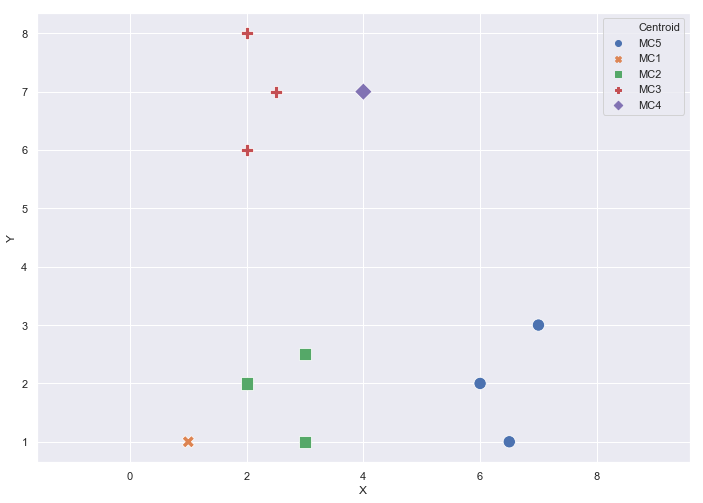

In [4]:
kmeans = KMeans(n_clusters=5, random_state=0, init=centroids).fit(initial[['X', 'Y']])
labels = kmeans.labels_
# Change the cluster labels from just numbers like 0, 1, 2 to MC1, MC2, etc
labels = ['MC'+str((x+1)) for x in labels]
initial['Centroid'] = labels
display(initial)

# Plot the K-means output with assignments
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="X", y="Y", style="Centroid", hue="Centroid", data=initial, s=150)

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()

### After the initial batch K-Means step, comes the online phase, where new data points arrive one by one. For this, we maintain micro-cluster summaries and update them incrementally as new points arrive. A new point p is handled as follows:
##### 1. Compute the distances between p and each of the q maintained micro-cluster centroids
##### 2. For the closest micro-cluster to p, calculate its max boundary
##### 3. If p is within max boundary, add p to the micro-cluster.
##### 4. If not, delete 1 micro-cluster or merge 2 of the closest located micro-clusters, and create a new micro-cluster with p.
### First, we initialize the micro-cluster summary structure

In [5]:
d = {'CF1(X)': [0.0] * 5, 'CF2(X)': [0.0] * 5, 'CF1(Y)': [0.0] * 5, 'CF2(Y)': [0.0] * 5, 'CF1(T)': [0.0] * 5, 
     'CF2(T)': [0.0] * 5, 'N': [0] * 5, 'MicroCluster': ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']}
cft = pd.DataFrame(d).set_index('MicroCluster')

for row in initial.itertuples():
    c = row.Centroid
    
    cft.at[c, 'CF1(X)'] += row.X
    cft.at[c, 'CF2(X)'] += row.X**2
    
    cft.at[c, 'CF1(Y)'] += row.Y
    cft.at[c, 'CF2(Y)'] += row.Y**2
    
    cft.at[c, 'CF1(T)'] += row.Index
    cft.at[c, 'CF2(T)'] += row.Index**2
    
    cft.at[c, 'N'] += 1

    
# Micro-cluster details
d = {'Center(X)': [0.0] * 5, 'Center(Y)': [0.0] * 5, 'Radius(X)': [0.0] * 5, 'Radius(Y)': [0.0] * 5, 'Mean(T)': [0.0] * 5, 
     'Sigma(T)': [0.0] * 5, 'Radius': [0.0] * 5, 'Max Radius': [0.0] * 5, 'MicroCluster': ['MC1', 'MC2', 'MC3', 'MC4', 'MC5']}
mc_details = pd.DataFrame(d).set_index('MicroCluster')

def recalculate_mc_stats():
    for index, row in cft.iterrows():
    
        mc_details.at[index, 'Center(X)'] = row['CF1(X)']/row['N']
        mc_details.at[index, 'Center(Y)'] = row['CF1(Y)']/row['N']

        radius_x = math.sqrt( row['CF2(X)']/row['N'] - (row['CF1(X)']/row['N'])**2 )
        radius_y = math.sqrt( row['CF2(Y)']/row['N'] - (row['CF1(Y)']/row['N'])**2 )
        radius = np.mean([radius_x, radius_y])
        mc_details.at[index, 'Radius(X)'] = radius_x
        mc_details.at[index, 'Radius(Y)'] = radius_y
        mc_details.at[index, 'Radius'] = radius

        mc_details.at[index, 'Mean(T)'] = row['CF1(T)']/row['N']
        mc_details.at[index, 'Sigma(T)'] = math.sqrt( row['CF2(T)']/row['N'] - (row['CF1(T)']/row['N'])**2 )

        mc_details.at[index, 'Max Radius'] = radius * 2
        
recalculate_mc_stats()

#display(cft)
#display(mc_details)
cft_combined = pd.concat([cft, mc_details], axis=1)
display(cft_combined)

,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC1,1.0,1.00,1.0,1.00,4.0,16.0,1,1.000000,1.000000,0.000000,0.000000,4.0,0.000000,0.000000,0.000000
MC2,8.0,22.00,5.5,11.25,18.0,110.0,3,2.666667,1.833333,0.471405,0.623610,6.0,0.816497,0.547507,1.095014
MC3,6.5,14.25,21.0,149.00,27.0,245.0,3,2.166667,7.000000,0.235702,0.816497,9.0,0.816497,0.526099,1.052199
MC4,4.0,16.00,7.0,49.00,11.0,121.0,1,4.000000,7.000000,0.000000,0.000000,11.0,0.000000,0.000000,0.000000
MC5,19.5,127.25,6.0,14.00,6.0,14.0,3,6.500000,2.000000,0.408248,0.816497,2.0,0.816497,0.612372,1.224745


### In the data structures above, the Micro-Cluster summaries are calculated from the initial points. Now, we can use the summary information to handle new data points

# TIMEPOINT 12

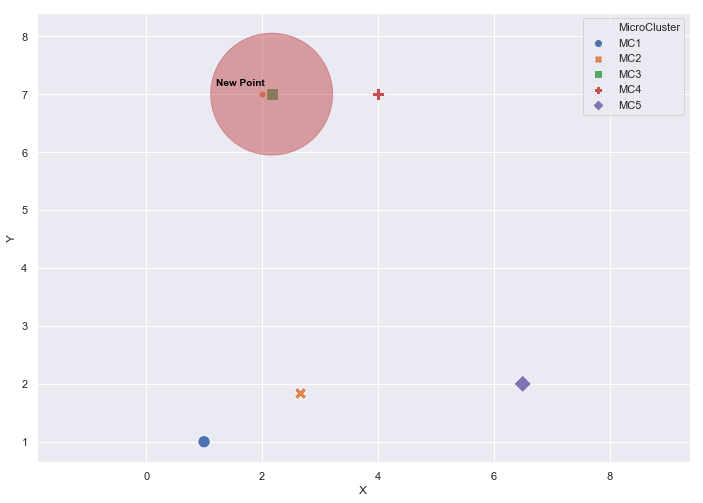

In [6]:
# Plot the current micro clusters
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="Center(X)", y="Center(Y)", style="MicroCluster", hue="MicroCluster", data=cft_combined.reset_index(), s=150)


# New point
p1 = sns.scatterplot(x="X", y="Y", data=online.loc[[12]], s=50)
p1.text(2-0.8, 7+0.15, "New Point", horizontalalignment='left', size='medium', color='black', weight='semibold')


# Plot the micro cluster radius
ax.add_patch(plt.Circle((cft_combined.loc['MC3']['Center(X)'], cft_combined.loc['MC3']['Center(Y)']),
                        1.052199, color='r', alpha=0.5))

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()

### New point at T12: (2, 7)
### The point falls inside the Max Boundary of the closest Micro-Cluster MC3, so it is absorbed.

In [7]:
def add_to_mc(microcluster, x, y, t):
    # Increment LS for X
    cft_combined.at[microcluster, 'CF1(X)'] += x
    # Increment SS for X
    cft_combined.at[microcluster, 'CF2(X)'] += x**2
    # Increment LS for Y
    cft_combined.at[microcluster, 'CF1(Y)'] += y
    # Increment SS for Yhttp://localhost:8888/notebooks/clustream.ipynb#New-point-at-T12:-(2,-7)
    cft_combined.at[microcluster, 'CF2(Y)'] += y**2
    # Increment LS for T
    cft_combined.at[microcluster, 'CF1(T)'] += t
    # Increment SS for T
    cft_combined.at[microcluster, 'CF2(T)'] += t**2
    # Increment N
    cft_combined.at[microcluster, 'N'] += 1

def create_new_mc(x, y, t, mc_name):

    d = {'CF1(X)': x, 'CF2(X)': x**2, 'CF1(Y)': y, 'CF2(Y)': y**2, 'CF1(T)': t, 'CF2(T)': t**2, 'N': 1}
    row = pd.Series(d, name=mc_name)
    df = cft_combined.append(row)
    df.fillna(0, inplace=True)
    return df

def delete_oldest_mc():
    # idxmin() returns the index of the oldest value of the column
    oldest_mc = cft_combined['Mean(T)'].idxmin()
    return cft_combined.drop(oldest_mc)

def merge_mc(mc1, mc2, new_mc):
    feature_vector = ['CF1(X)', 'CF2(X)', 'CF1(Y)', 'CF2(Y)', 'CF1(T)', 'CF2(T)', 'N']
    for column in feature_vector:
        cft_combined.at[new_mc, column] = cft_combined.at[mc1, column] + cft_combined.at[mc2, column]
    cft_combined.drop([mc1, mc2], inplace=True)
    cft_combined.fillna(0, inplace=True)
    return cft_combined
        

def recalculate_summaries():
        
    for index, row in cft_combined.iterrows():
    
        cft_combined.at[index, 'Center(X)'] = row['CF1(X)']/row['N']
        cft_combined.at[index, 'Center(Y)'] = row['CF1(Y)']/row['N']

        radius_x = math.sqrt( row['CF2(X)']/row['N'] - (row['CF1(X)']/row['N'])**2 )
        radius_y = math.sqrt( row['CF2(Y)']/row['N'] - (row['CF1(Y)']/row['N'])**2 )
        radius = np.mean([radius_x, radius_y])
        cft_combined.at[index, 'Radius(X)'] = radius_x
        cft_combined.at[index, 'Radius(Y)'] = radius_y
        cft_combined.at[index, 'Radius'] = radius

        cft_combined.at[index, 'Mean(T)'] = row['CF1(T)']/row['N']
        cft_combined.at[index, 'Sigma(T)'] = math.sqrt( row['CF2(T)']/row['N'] - (row['CF1(T)']/row['N'])**2 )

        cft_combined.at[index, 'Max Radius'] = radius * 2


### Since the new point is absorbed by MC3, its feature vector (highlighted) is updated. 
### The feature vectors BEFORE and AFTER adding the new point are displayed

In [8]:
display(cft_combined)

# Add the new point
new_point = list(online.loc[[12]].iloc[0])
add_to_mc('MC3', new_point[0], new_point[1], 12)

# Recalculate cluster summaries
recalculate_summaries()
cft_combined.copy().style.apply(lambda x: ['background: lightgreen' if x.name == 'MC3'
                              else '' for i in x], axis=1)

,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC1,1.0,1.00,1.0,1.00,4.0,16.0,1,1.000000,1.000000,0.000000,0.000000,4.0,0.000000,0.000000,0.000000
MC2,8.0,22.00,5.5,11.25,18.0,110.0,3,2.666667,1.833333,0.471405,0.623610,6.0,0.816497,0.547507,1.095014
MC3,6.5,14.25,21.0,149.00,27.0,245.0,3,2.166667,7.000000,0.235702,0.816497,9.0,0.816497,0.526099,1.052199
MC4,4.0,16.00,7.0,49.00,11.0,121.0,1,4.000000,7.000000,0.000000,0.000000,11.0,0.000000,0.000000,0.000000
MC5,19.5,127.25,6.0,14.00,6.0,14.0,3,6.500000,2.000000,0.408248,0.816497,2.0,0.816497,0.612372,1.224745


,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC1,1,1,1,1,4,16,1,1,1,0,0,4,0,0,0
MC2,8,22,5.5,11.25,18,110,3,2.66667,1.83333,0.471405,0.62361,6,0.816497,0.547507,1.09501
MC3,8.5,18.25,28,198,39,389,4,2.125,7,0.216506,0.707107,9.75,1.47902,0.461807,0.923613
MC4,4,16,7,49,11,121,1,4,7,0,0,11,0,0,0
MC5,19.5,127.25,6,14,6,14,3,6.5,2,0.408248,0.816497,2,0.816497,0.612372,1.22474


# TIMEPOINT 13

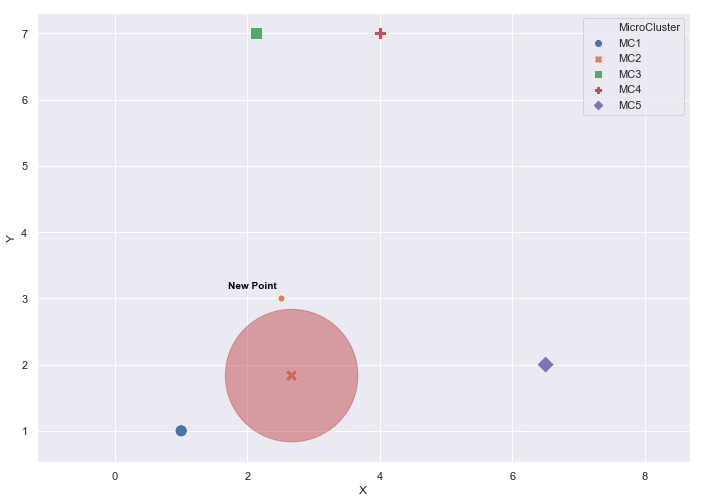

In [9]:
timepoint = 13
# Plot the current micro clusters
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="Center(X)", y="Center(Y)", style="MicroCluster", hue="MicroCluster", data=cft_combined.reset_index(), s=150)


# New point
p1 = sns.scatterplot(x="X", y="Y", data=online.loc[[timepoint]], s=50)
p1.text(2.5-0.8, 3+0.15, "New Point", horizontalalignment='left', size='medium', color='black', weight='semibold')


# Plot the micro cluster radius
ax.add_patch(plt.Circle((cft_combined.loc['MC2']['Center(X)'], cft_combined.loc['MC2']['Center(Y)']),
                        1, color='r', alpha=0.5))

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()

### New point at T13: (2.5, 3)
### The point falls outside the Max Boundary of the closest Micro-Cluster MC2, so a new Micro-Cluster has to be created.
### In order to accommodate the new Micro-Cluster, an old one must be deleted. The oldest one currently is MC5

In [10]:
display(cft_combined)

# Add the new point
new_point = list(online.loc[[13]].iloc[0])
cft_combined = delete_oldest_mc()
cft_combined = create_new_mc(new_point[0], new_point[1], timepoint, 'MC6')

# Recalculate cluster summaries
recalculate_summaries()
cft_combined.copy().style.apply(lambda x: ['background: lightgreen' if x.name == 'MC6'
                              else '' for i in x], axis=1)

,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC1,1.0,1.00,1.0,1.00,4.0,16.0,1,1.000000,1.000000,0.000000,0.000000,4.00,0.000000,0.000000,0.000000
MC2,8.0,22.00,5.5,11.25,18.0,110.0,3,2.666667,1.833333,0.471405,0.623610,6.00,0.816497,0.547507,1.095014
MC3,8.5,18.25,28.0,198.00,39.0,389.0,4,2.125000,7.000000,0.216506,0.707107,9.75,1.479020,0.461807,0.923613
MC4,4.0,16.00,7.0,49.00,11.0,121.0,1,4.000000,7.000000,0.000000,0.000000,11.00,0.000000,0.000000,0.000000
MC5,19.5,127.25,6.0,14.00,6.0,14.0,3,6.500000,2.000000,0.408248,0.816497,2.00,0.816497,0.612372,1.224745


,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC1,1,1,1,1,4,16,1,1,1,0,0,4,0,0,0
MC2,8,22,5.5,11.25,18,110,3,2.66667,1.83333,0.471405,0.62361,6,0.816497,0.547507,1.09501
MC3,8.5,18.25,28,198,39,389,4,2.125,7,0.216506,0.707107,9.75,1.47902,0.461807,0.923613
MC4,4,16,7,49,11,121,1,4,7,0,0,11,0,0,0
MC6,2.5,6.25,3,9,13,169,1,2.5,3,0,0,13,0,0,0


# TIMEPOINT 14

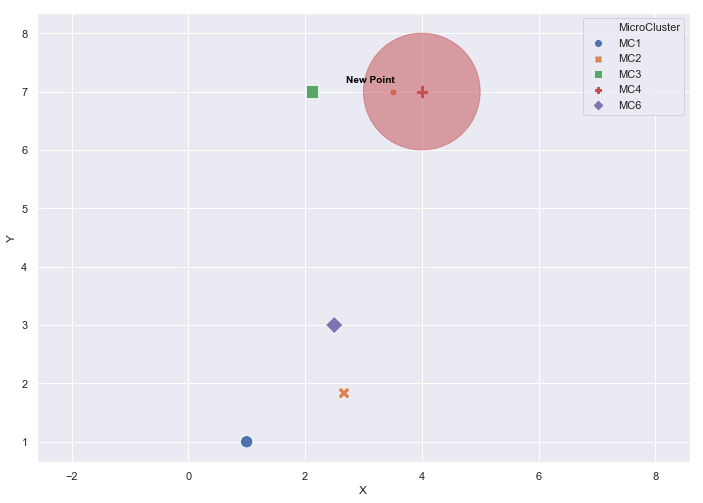

In [11]:
timepoint = 14

# Plot the current micro clusters
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="Center(X)", y="Center(Y)", style="MicroCluster", hue="MicroCluster", data=cft_combined.reset_index(), s=150)


# New point
p1 = sns.scatterplot(x="X", y="Y", data=online.loc[[timepoint]], s=50)
p1.text(3.5-0.8, 7+0.15, "New Point", horizontalalignment='left', size='medium', color='black', weight='semibold')


# Plot the micro cluster radius
ax.add_patch(plt.Circle((cft_combined.loc['MC4']['Center(X)'], cft_combined.loc['MC4']['Center(Y)']),
                        1, color='r', alpha=0.5))

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()

### New point at T14: (3.5, 7)
### The point falls inside the Max Boundary of the closest Micro-Cluster MC4, so it is absorbed.

In [12]:
display(cft_combined)

# Add the new point
new_point = list(online.loc[[timepoint]].iloc[0])
add_to_mc('MC4', new_point[0], new_point[1], timepoint)

# Recalculate cluster summaries
recalculate_summaries()
cft_combined.copy().style.apply(lambda x: ['background: lightgreen' if x.name == 'MC4'
                              else '' for i in x], axis=1)

,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC1,1.0,1.00,1.0,1.00,4.0,16.0,1.0,1.000000,1.000000,0.000000,0.000000,4.00,0.000000,0.000000,0.000000
MC2,8.0,22.00,5.5,11.25,18.0,110.0,3.0,2.666667,1.833333,0.471405,0.623610,6.00,0.816497,0.547507,1.095014
MC3,8.5,18.25,28.0,198.00,39.0,389.0,4.0,2.125000,7.000000,0.216506,0.707107,9.75,1.479020,0.461807,0.923613
MC4,4.0,16.00,7.0,49.00,11.0,121.0,1.0,4.000000,7.000000,0.000000,0.000000,11.00,0.000000,0.000000,0.000000
MC6,2.5,6.25,3.0,9.00,13.0,169.0,1.0,2.500000,3.000000,0.000000,0.000000,13.00,0.000000,0.000000,0.000000


,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC1,1,1,1,1,4,16,1,1,1,0,0,4,0,0,0
MC2,8,22,5.5,11.25,18,110,3,2.66667,1.83333,0.471405,0.62361,6,0.816497,0.547507,1.09501
MC3,8.5,18.25,28,198,39,389,4,2.125,7,0.216506,0.707107,9.75,1.47902,0.461807,0.923613
MC4,7.5,28.25,14,98,25,317,2,3.75,7,0.25,0,12.5,1.5,0.125,0.25
MC6,2.5,6.25,3,9,13,169,1,2.5,3,0,0,13,0,0,0


# TIMEPOINT 15

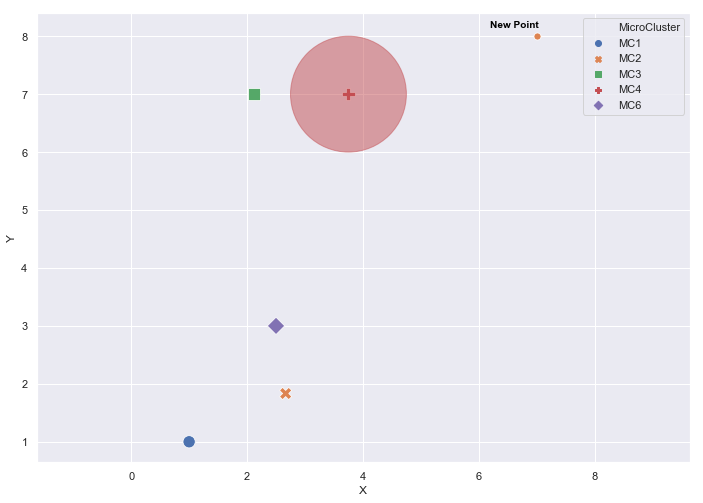

In [13]:
timepoint = 15
# Plot the current micro clusters
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="Center(X)", y="Center(Y)", style="MicroCluster", hue="MicroCluster", data=cft_combined.reset_index(), s=150)


# New point
p1 = sns.scatterplot(x="X", y="Y", data=online.loc[[timepoint]], s=50)
p1.text(7-0.8, 8+0.15, "New Point", horizontalalignment='left', size='medium', color='black', weight='semibold')


# Plot the micro cluster radius
ax.add_patch(plt.Circle((cft_combined.loc['MC4']['Center(X)'], cft_combined.loc['MC4']['Center(Y)']),
                        1, color='r', alpha=0.5))

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()

### New point at T15: (7, 8)
### The point falls outside the Max Boundary of the closest Micro-Cluster MC4, so a new Micro-Cluster has to be created.
### In order to accommodate the new Micro-Cluster, an old one must be deleted. The oldest one currently is MC1

In [14]:
display(cft_combined.copy().style.apply(lambda x: ['background: lightcoral' if x.name == 'MC1'
                                                   else '' for i in x], axis=1))

# Add the new point
new_point = list(online.loc[[timepoint]].iloc[0])
cft_combined = delete_oldest_mc()
cft_combined = create_new_mc(new_point[0], new_point[1], timepoint, 'MC7')

# Recalculate cluster summaries
recalculate_summaries()
cft_combined.copy().style.apply(lambda x: ['background: lightgreen' if x.name == 'MC7'
                              else '' for i in x], axis=1)

,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC1,1,1,1,1,4,16,1,1,1,0,0,4,0,0,0
MC2,8,22,5.5,11.25,18,110,3,2.66667,1.83333,0.471405,0.62361,6,0.816497,0.547507,1.09501
MC3,8.5,18.25,28,198,39,389,4,2.125,7,0.216506,0.707107,9.75,1.47902,0.461807,0.923613
MC4,7.5,28.25,14,98,25,317,2,3.75,7,0.25,0,12.5,1.5,0.125,0.25
MC6,2.5,6.25,3,9,13,169,1,2.5,3,0,0,13,0,0,0


,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC2,8,22,5.5,11.25,18,110,3,2.66667,1.83333,0.471405,0.62361,6,0.816497,0.547507,1.09501
MC3,8.5,18.25,28,198,39,389,4,2.125,7,0.216506,0.707107,9.75,1.47902,0.461807,0.923613
MC4,7.5,28.25,14,98,25,317,2,3.75,7,0.25,0,12.5,1.5,0.125,0.25
MC6,2.5,6.25,3,9,13,169,1,2.5,3,0,0,13,0,0,0
MC7,7,49,8,64,15,225,1,7,8,0,0,15,0,0,0


# TIMEPOINT 16

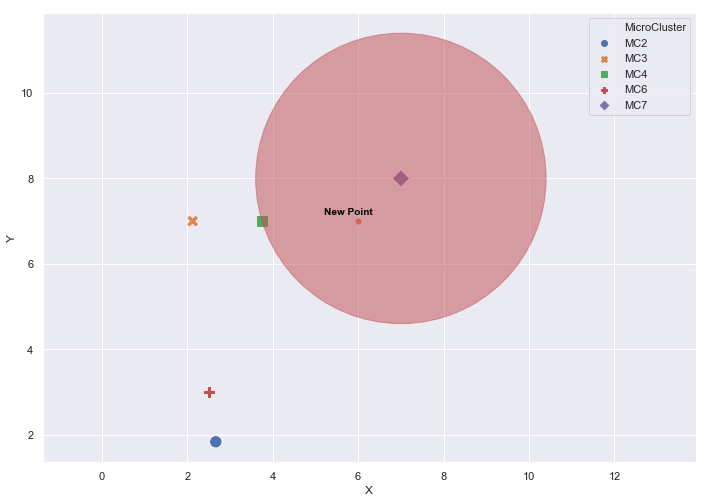

In [15]:
timepoint = 16
# Plot the current micro clusters
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="Center(X)", y="Center(Y)", style="MicroCluster", hue="MicroCluster", data=cft_combined.reset_index(), s=150)


# New point
p1 = sns.scatterplot(x="X", y="Y", data=online.loc[[timepoint]], s=50)
p1.text(6-0.8, 7+0.15, "New Point", horizontalalignment='left', size='medium', color='black', weight='semibold')


# Plot the micro cluster radius
ax.add_patch(plt.Circle((cft_combined.loc['MC7']['Center(X)'], cft_combined.loc['MC7']['Center(Y)']),
                        3.400368, color='r', alpha=0.5))

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()

### New point at T16: (6, 7)
### The point falls inside the Max Boundary of the closest Micro-Cluster MC7, so it is absorbed.
### NOTE: Max Boundary of a Micro-Cluster with only 1 data point is the distance to the closest Micro-Cluster

In [16]:
display(cft_combined)

# Add the new point
new_point = list(online.loc[[timepoint]].iloc[0])
add_to_mc('MC7', new_point[0], new_point[1], timepoint)

# Recalculate cluster summaries
recalculate_summaries()
cft_combined.copy().style.apply(lambda x: ['background: lightgreen' if x.name == 'MC7'
                              else '' for i in x], axis=1)

,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC2,8.0,22.00,5.5,11.25,18.0,110.0,3.0,2.666667,1.833333,0.471405,0.623610,6.00,0.816497,0.547507,1.095014
MC3,8.5,18.25,28.0,198.00,39.0,389.0,4.0,2.125000,7.000000,0.216506,0.707107,9.75,1.479020,0.461807,0.923613
MC4,7.5,28.25,14.0,98.00,25.0,317.0,2.0,3.750000,7.000000,0.250000,0.000000,12.50,1.500000,0.125000,0.250000
MC6,2.5,6.25,3.0,9.00,13.0,169.0,1.0,2.500000,3.000000,0.000000,0.000000,13.00,0.000000,0.000000,0.000000
MC7,7.0,49.00,8.0,64.00,15.0,225.0,1.0,7.000000,8.000000,0.000000,0.000000,15.00,0.000000,0.000000,0.000000


,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC2,8,22,5.5,11.25,18,110,3,2.66667,1.83333,0.471405,0.62361,6,0.816497,0.547507,1.09501
MC3,8.5,18.25,28,198,39,389,4,2.125,7,0.216506,0.707107,9.75,1.47902,0.461807,0.923613
MC4,7.5,28.25,14,98,25,317,2,3.75,7,0.25,0,12.5,1.5,0.125,0.25
MC6,2.5,6.25,3,9,13,169,1,2.5,3,0,0,13,0,0,0
MC7,13,85,15,113,31,481,2,6.5,7.5,0.5,0.5,15.5,0.5,0.5,1


# TIMEPOINT 17

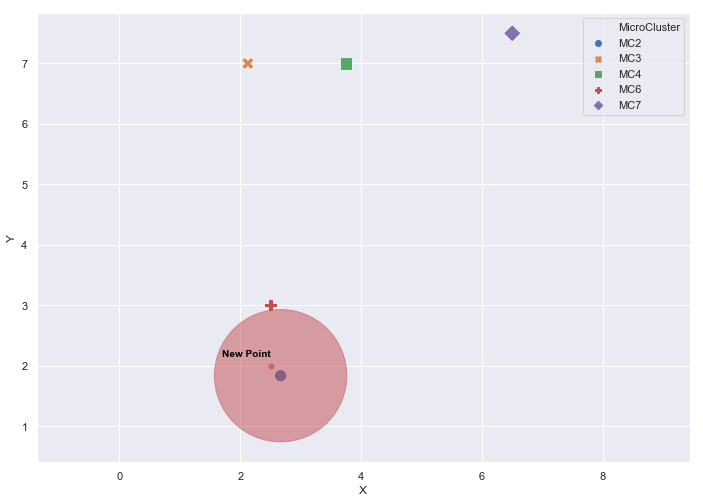

In [17]:
timepoint = 17
# Plot the current micro clusters
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="Center(X)", y="Center(Y)", style="MicroCluster", hue="MicroCluster", data=cft_combined.reset_index(), s=150)


# New point
p1 = sns.scatterplot(x="X", y="Y", data=online.loc[[timepoint]], s=50)
p1.text(2.5-0.8, 2+0.15, "New Point", horizontalalignment='left', size='medium', color='black', weight='semibold')


# Plot the micro cluster radius
ax.add_patch(plt.Circle((cft_combined.loc['MC2']['Center(X)'], cft_combined.loc['MC2']['Center(Y)']),
                        1.09501, color='r', alpha=0.5))

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()

### New point at T17: (2.5, 2)
### The point falls inside the Max Boundary of the closest Micro-Cluster MC2, so it is absorbed.

In [18]:
display(cft_combined)

# Add the new point
new_point = list(online.loc[[timepoint]].iloc[0])
add_to_mc('MC2', new_point[0], new_point[1], timepoint)

# Recalculate cluster summaries
recalculate_summaries()
cft_combined.copy().style.apply(lambda x: ['background: lightgreen' if x.name == 'MC2'
                              else '' for i in x], axis=1)

,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC2,8.0,22.00,5.5,11.25,18.0,110.0,3.0,2.666667,1.833333,0.471405,0.623610,6.00,0.816497,0.547507,1.095014
MC3,8.5,18.25,28.0,198.00,39.0,389.0,4.0,2.125000,7.000000,0.216506,0.707107,9.75,1.479020,0.461807,0.923613
MC4,7.5,28.25,14.0,98.00,25.0,317.0,2.0,3.750000,7.000000,0.250000,0.000000,12.50,1.500000,0.125000,0.250000
MC6,2.5,6.25,3.0,9.00,13.0,169.0,1.0,2.500000,3.000000,0.000000,0.000000,13.00,0.000000,0.000000,0.000000
MC7,13.0,85.00,15.0,113.00,31.0,481.0,2.0,6.500000,7.500000,0.500000,0.500000,15.50,0.500000,0.500000,1.000000


,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC2,10.5,28.25,7.5,15.25,35,399,4,2.625,1.875,0.414578,0.544862,8.75,4.81534,0.47972,0.95944
MC3,8.5,18.25,28,198,39,389,4,2.125,7,0.216506,0.707107,9.75,1.47902,0.461807,0.923613
MC4,7.5,28.25,14,98,25,317,2,3.75,7,0.25,0,12.5,1.5,0.125,0.25
MC6,2.5,6.25,3,9,13,169,1,2.5,3,0,0,13,0,0,0
MC7,13,85,15,113,31,481,2,6.5,7.5,0.5,0.5,15.5,0.5,0.5,1


# TIMEPOINT 18

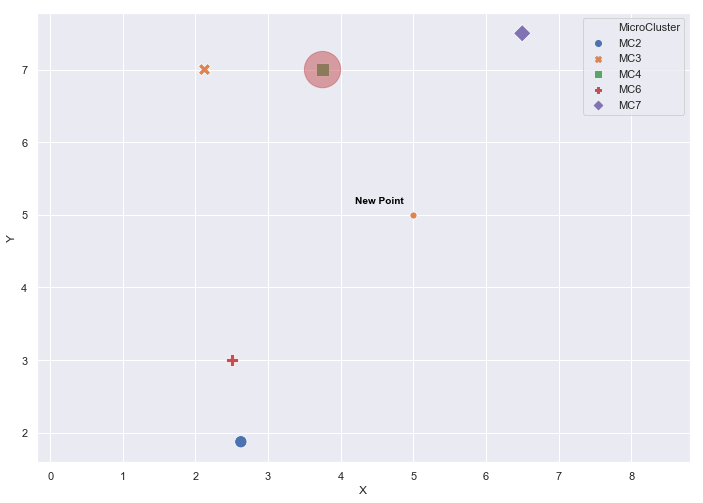

In [19]:
timepoint = 18
# Plot the current micro clusters
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="Center(X)", y="Center(Y)", style="MicroCluster", hue="MicroCluster", data=cft_combined.reset_index(), s=150)


# New point
p1 = sns.scatterplot(x="X", y="Y", data=online.loc[[timepoint]], s=50)
p1.text(5-0.8, 5+0.15, "New Point", horizontalalignment='left', size='medium', color='black', weight='semibold')


# Plot the micro cluster radius
ax.add_patch(plt.Circle((cft_combined.loc['MC4']['Center(X)'], cft_combined.loc['MC4']['Center(Y)']),
                        0.25, color='r', alpha=0.5))

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()

### New point at T18: (5, 5)
### The point falls outside the Max Boundary of the closest Micro-Cluster MC4, so a new Micro-Cluster has to be created.
### In order to accommodate the new Micro-Cluster, we first try to delete a Micro-Cluster. Currently, all Micro-Clusters fulfill the relevency threshold, so two of the closest Micro-Clusters should be merged. 
### MC2 and MC6 are currently the closest

In [20]:
display(cft_combined.copy().style.apply(lambda x: ['background: lightcoral' if x.name == 'MC2' or x.name == 'MC6'
                                                   else '' for i in x], axis=1))

cft_combined = merge_mc(mc1='MC2', mc2='MC6', new_mc='MC8')
recalculate_summaries()

# Add the new point
new_point = list(online.loc[[timepoint]].iloc[0]) 
cft_combined = create_new_mc(new_point[0], new_point[1], timepoint, 'MC9')

# Recalculate cluster summaries
recalculate_summaries()
cft_combined.copy().style.apply(lambda x: ['background: lightgreen' if x.name == 'MC9'
                              else '' for i in x], axis=1)

,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC2,10.5,28.25,7.5,15.25,35,399,4,2.625,1.875,0.414578,0.544862,8.75,4.81534,0.47972,0.95944
MC3,8.5,18.25,28,198,39,389,4,2.125,7,0.216506,0.707107,9.75,1.47902,0.461807,0.923613
MC4,7.5,28.25,14,98,25,317,2,3.75,7,0.25,0,12.5,1.5,0.125,0.25
MC6,2.5,6.25,3,9,13,169,1,2.5,3,0,0,13,0,0,0
MC7,13,85,15,113,31,481,2,6.5,7.5,0.5,0.5,15.5,0.5,0.5,1


,CF1(X),CF2(X),CF1(Y),CF2(Y),CF1(T),CF2(T),N,Center(X),Center(Y),Radius(X),Radius(Y),Mean(T),Sigma(T),Radius,Max Radius
MicroCluster,,,,,,,,,,,,,,,
MC3,8.5,18.25,28,198,39,389,4,2.125,7,0.216506,0.707107,9.75,1.47902,0.461807,0.923613
MC4,7.5,28.25,14,98,25,317,2,3.75,7,0.25,0,12.5,1.5,0.125,0.25
MC7,13,85,15,113,31,481,2,6.5,7.5,0.5,0.5,15.5,0.5,0.5,1
MC8,13,34.5,10.5,24.25,48,568,5,2.6,2.1,0.374166,0.663325,9.6,4.63033,0.518745,1.03749
MC9,5,25,5,25,18,324,1,5,5,0,0,18,0,0,0


### We reached the end of the stream. The final Micro-Clusters are plotted below.

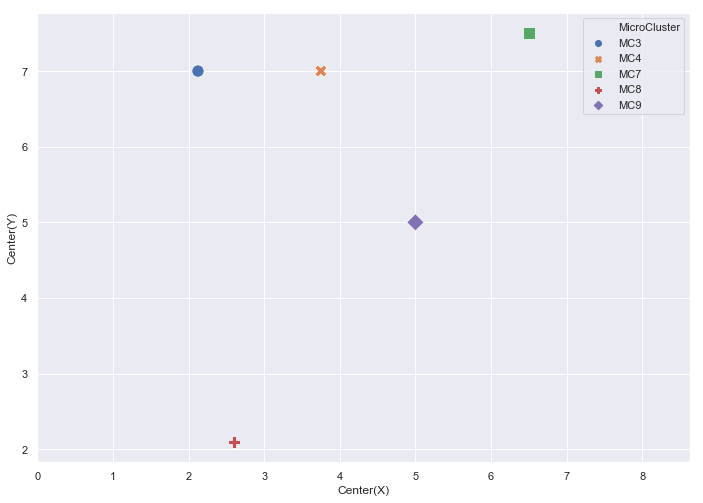

In [25]:
# Plot the current micro clusters
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="Center(X)", y="Center(Y)", style="MicroCluster", hue="MicroCluster", data=cft_combined.reset_index(), s=150)

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()

### Now, we run an offline K-Means algorithm with k centroids, in order to get k final clusters.
### The centers are initialized proportional to the number of points in a given microcluster.
### We are manually initializing the centroids to the values below:

In [24]:
d = {'Centers': ['C1', 'C2', 'C3',], 'X': [3, 3.5, 6], 'Y': [3, 6, 6.5]}
weighted_centroids = pd.DataFrame(d).set_index('Centers')
weighted_centroids

,X,Y
Centers,,
C1,3.0,3.0
C2,3.5,6.0
C3,6.0,6.5


,Center(X),Center(Y),Centroid
MicroCluster,,,
MC3,2.125,7.0,MC2
MC4,3.750,7.0,MC2
MC7,6.500,7.5,MC3
MC8,2.600,2.1,MC1
MC9,5.000,5.0,MC2


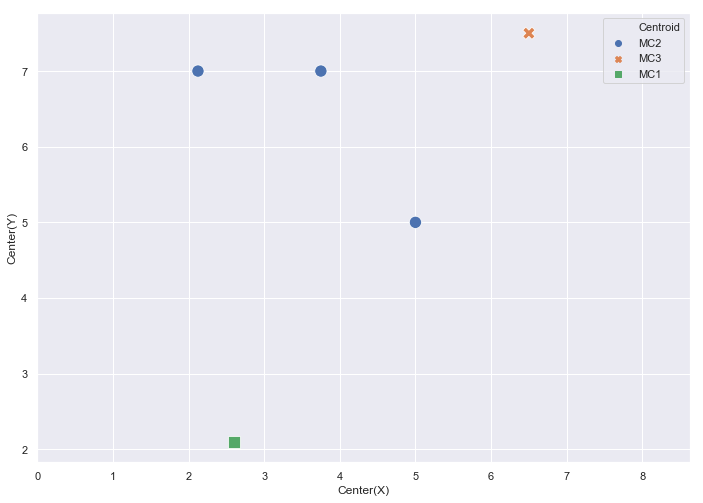

In [50]:
microclusters = cft_combined[['Center(X)', 'Center(Y)']]
kmeans = KMeans(n_clusters=3, random_state=0, init=weighted_centroids)
kmeans.fit(microclusters)

labels = kmeans.labels_
# Change the cluster labels from just numbers like 0, 1, 2 to MC1, MC2, etc
labels = ['MC'+str((x+1)) for x in labels]
microclusters['Centroid'] = labels
display(microclusters)

# Plot the K-means output with assignments
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.scatterplot(x="Center(X)", y="Center(Y)", style="Centroid", hue="Centroid", data=microclusters, s=150)

#Use adjustable='box-forced' to make the plot area square-shaped as well.
ax.set_aspect('equal', adjustable='datalim')
ax.plot()   #Causes an autoscale update.
plt.show()